In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd

# Load your merged Safdarjung data
file_path = "/content/drive/MyDrive/ML_work/datafiles/station_data/safdarjung_merged.csv"
df = pd.read_csv(file_path, parse_dates=['datetime'])

# Rename for consistency
df.rename(columns={'datetime': 'date'}, inplace=True)

# Sort by date
df = df.sort_values('date').reset_index(drop=True)
df.head()



,date,DBT,WBT,DPT,RH,SLP,MSLP,max,min,heatwave
0,1970-03-01,15.000000,14.500000,14.150000,94.500000,990.500,1016.000000,23.1,13.6,9.5
1,1970-03-02,17.825000,13.125000,8.975000,58.750000,989.700,1014.975000,24.1,11.1,13.0
2,1970-03-03,17.283333,12.633333,8.333333,57.666667,988.400,1013.716667,22.5,9.1,13.4
3,1970-03-04,17.262500,12.800000,8.425000,59.625000,987.375,1012.575000,23.0,10.6,12.4
4,1970-03-05,17.375000,13.125000,9.287500,62.375000,986.675,1011.862500,24.8,11.2,13.6


In [3]:
df['doy'] = df['date'].dt.dayofyear

# Filter for climatology (1993–2023) and compute normal max temp
climatology = df[(df['date'].dt.year >= 1993) & (df['date'].dt.year <= 2023)]
normal_temp = climatology.groupby('doy')['max'].mean().reset_index()
normal_temp.rename(columns={'max': 'normal_max'}, inplace=True)

# Merge with main df
df = df.merge(normal_temp, on='doy', how='left')


In [4]:
# Calculate departure from normal
df['departure'] = df['max'] - df['normal_max']

# Heatwave condition (any one condition)
df['heatwave'] = (
    ((df['departure'] >= 4.5) & (df['departure'] <= 6.4)) |
    (df['normal_max'] >= 40)
).astype(int)

# Severe heatwave condition (any one condition)
df['severe_heatwave'] = (
    (df['departure'] > 6.4) |
    (df['normal_max'] >= 40)
).astype(int)


In [5]:
# Lagging only max, min, and normal_max (1–5 days)
for feature in ['max', 'min', 'normal_max']:
    for lag in range(1, 6):
        df[f'{feature}_lag{lag}'] = df[feature].shift(lag)

# Drop rows with missing lag data
df = df.dropna().reset_index(drop=True)


In [6]:
# Save forecast-ready dataset to current working directory
df.to_csv("safdarjung_forecast_ready_data.csv", index=False)


In [7]:
from google.colab import files
files.download("safdarjung_forecast_ready_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ML_work/datafiles/forecast_data/safdarjung_forecast_ready_data.csv")


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

train_df = df[df['year'] <= 2023].copy()
valid_df = df[df['year'] == 2024].copy()


In [ ]:
# Features: only lag features (as per Model 1)
feature_cols = [col for col in df.columns if 'lag' in col]

X_train = train_df[feature_cols]
y_train = train_df['heatwave']

X_valid = valid_df[feature_cols]
y_valid = valid_df['heatwave']


In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'  # useful if classes are imbalanced
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       random_state=42)

📌 Accuracy: 0.9468085106382979

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97        79
           1       0.78      0.93      0.85        15

    accuracy                           0.95        94
   macro avg       0.88      0.94      0.91        94
weighted avg       0.95      0.95      0.95        94


📌 Confusion Matrix:


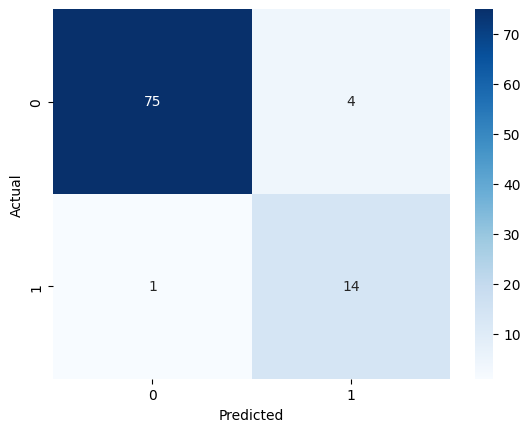

In [ ]:
y_pred = rf.predict(X_valid)

print("📌 Accuracy:", accuracy_score(y_valid, y_pred))
print("\n📌 Classification Report:\n", classification_report(y_valid, y_pred))
print("\n📌 Confusion Matrix:")
sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


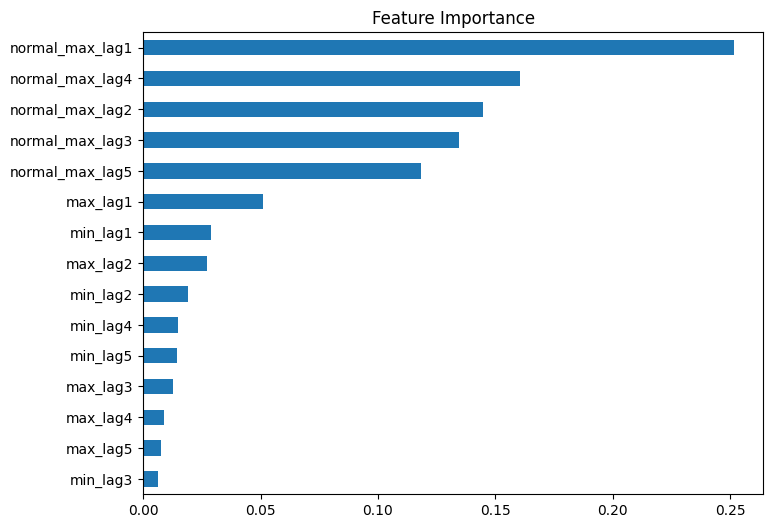

In [ ]:
importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6), title="Feature Importance")
plt.show()


In [ ]:
!pip install lightgbm


In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [ ]:
# Feature columns (only lag features)
feature_cols = [col for col in df.columns if 'lag' in col]

X_train = train_df[feature_cols]
y_train = train_df['heatwave']

X_valid = valid_df[feature_cols]
y_valid = valid_df['heatwave']


In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)


In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'is_unbalance': True,         # Handle class imbalance
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 5,
    'verbose': -1,
    'random_state': 42
}


In [ ]:
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=100)]
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0739757	valid_1's binary_logloss: 0.134235


📌 Accuracy: 0.9574468085106383

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97        79
           1       0.82      0.93      0.88        15

    accuracy                           0.96        94
   macro avg       0.91      0.95      0.92        94
weighted avg       0.96      0.96      0.96        94


📌 Confusion Matrix:


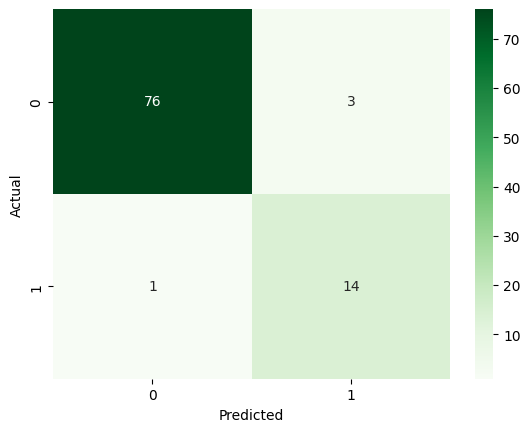

In [ ]:
y_pred_prob = model.predict(X_valid)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("📌 Accuracy:", accuracy_score(y_valid, y_pred))
print("\n📌 Classification Report:\n", classification_report(y_valid, y_pred))
print("\n📌 Confusion Matrix:")
sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#ACTUAL VS PREDICTED HEATWAVE TIMELINE

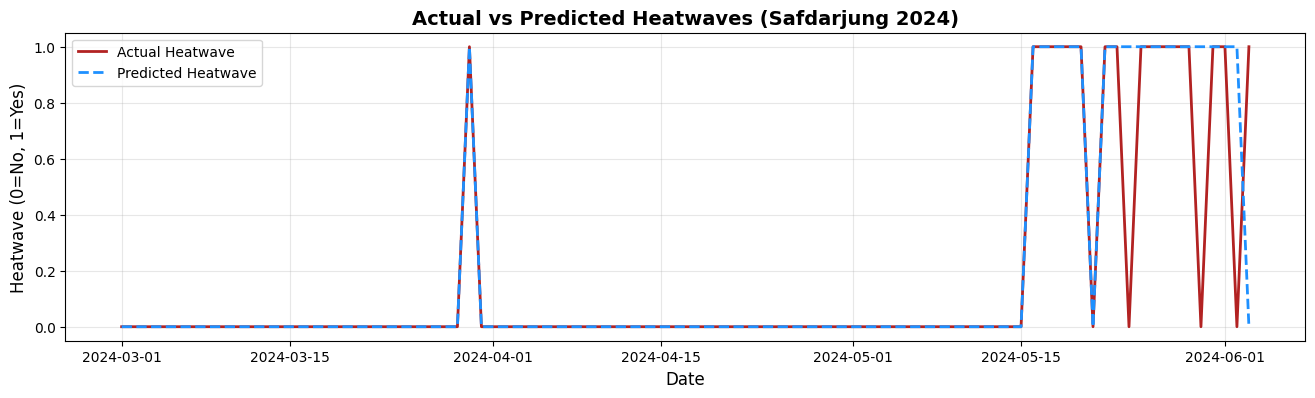

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(valid_df['date'], y_valid, label="Actual Heatwave", color='firebrick', linewidth=2)
plt.plot(valid_df['date'], y_pred, label="Predicted Heatwave", color='dodgerblue', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Heatwaves (Safdarjung 2024)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Heatwave (0=No, 1=Yes)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


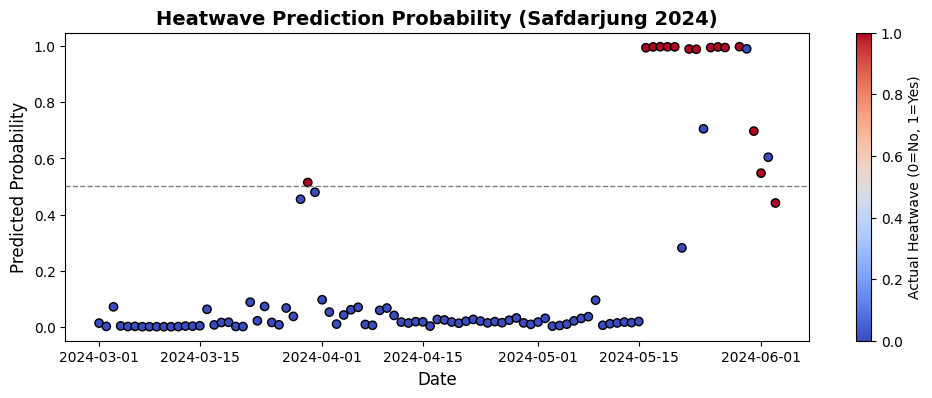

In [ ]:
y_pred_prob = model.predict(X_valid)  # Already computed during LightGBM

plt.figure(figsize=(12,4))
plt.scatter(valid_df['date'], y_pred_prob, c=y_valid, cmap='coolwarm', edgecolors='k')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.title("Heatwave Prediction Probability (Safdarjung 2024)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Predicted Probability", fontsize=12)
plt.colorbar(label="Actual Heatwave (0=No, 1=Yes)")
plt.show()


#DAILY Tmax Vs Normal Tmax

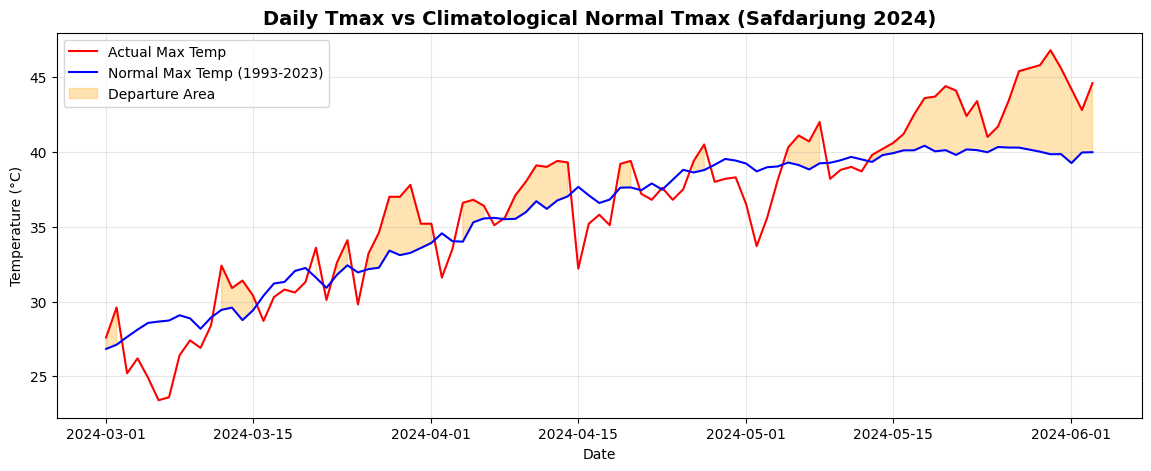

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(valid_df['date'], valid_df['max'], label="Actual Max Temp", color='red')
plt.plot(valid_df['date'], valid_df['normal_max'], label="Normal Max Temp (1993-2023)", color='blue')
plt.fill_between(valid_df['date'], valid_df['normal_max'], valid_df['max'],
                 where=(valid_df['max'] > valid_df['normal_max']), color='orange', alpha=0.3, label="Departure Area")
plt.title("Daily Tmax vs Climatological Normal Tmax (Safdarjung 2024)", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


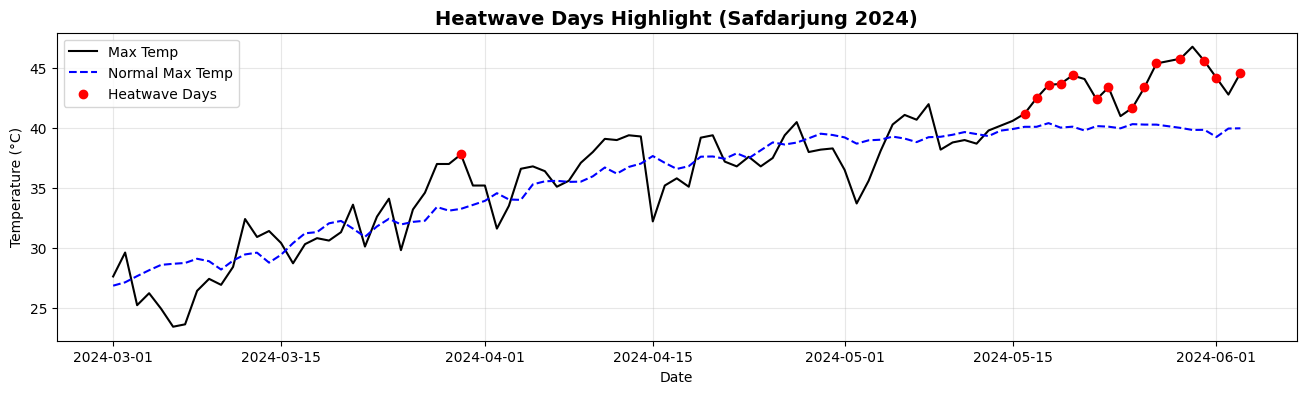

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(valid_df['date'], valid_df['max'], color='black', label="Max Temp")
plt.plot(valid_df['date'], valid_df['normal_max'], color='blue', linestyle='--', label="Normal Max Temp")

# Shade heatwave days
hw_days = valid_df['heatwave'] == 1
plt.scatter(valid_df.loc[hw_days, 'date'], valid_df.loc[hw_days, 'max'],
            color='red', label='Heatwave Days', zorder=5)

plt.title("Heatwave Days Highlight (Safdarjung 2024)", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
